In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls

drive  sample_data


In [0]:
!ls
%cd /content/drive/My Drive

drive  sample_data
/content/drive/My Drive


In [0]:
!ls

 beach.jpg	    Dogs-Vs-Cats-Kaggle  'Getting started.pdf'
'Colab Notebooks'   first.ipynb


In [0]:
!git clone https://github.com/gitshanks/fer2013.git

Cloning into 'fer2013'...
remote: Enumerating objects: 152, done.
remote: Total 152 (delta 0), reused 0 (delta 0), pack-reused 152
Receiving objects: 100% (152/152), 22.46 MiB | 15.84 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [0]:
!ls

 beach.jpg	    Dogs-Vs-Cats-Kaggle   first.ipynb
'Colab Notebooks'   fer2013		 'Getting started.pdf'


In [0]:
%cd fer2013
!ls

/content/drive/My Drive/fer2013
confmatrix.py	     fertestcustom.py			  predy.npy
confusionmatrix.png  fertest.py				  preprocessing.py
Expressions	     fertrain.py			  README.md
fdataX.npy	     flabels.npy			  test.jpg
fer2013.csv	     haarcascade_frontalface_default.xml  truey.npy
fer.h5		     modXtest.npy
fer.json	     modytest.npy


In [0]:

import numpy as np
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

data = pd.read_csv('fer2013.csv')

width, height = 48, 48

datapoints = data['pixels'].tolist()

#getting features for training
X = []
for xseq in datapoints:
    xx = [int(xp) for xp in xseq.split(' ')]
    xx = np.asarray(xx).reshape(width, height)
    X.append(xx.astype('float32'))

X = np.asarray(X)
X = np.expand_dims(X, -1)

#getting labels for training
y = pd.get_dummies(data['emotion']).as_matrix()

#storing them using numpy
np.save('fdataX', X)
np.save('flabels', y)

print("Preprocessing Done")
print("Number of Features: "+str(len(X[0])))
print("Number of Labels: "+ str(len(y[0])))
print("Number of examples in dataset:"+str(len(X)))
print("X,y stored in fdataX.npy and flabels.npy respectively")

Preprocessing Done
Number of Features: 48
Number of Labels: 7
Number of examples in dataset:35887
X,y stored in fdataX.npy and flabels.npy respectively


In [0]:
import sys, os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.models import model_from_json


num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

x = np.load('./fdataX.npy')
y = np.load('./flabels.npy')

x -= np.mean(x, axis=0)
x /= np.std(x, axis=0)

#for xx in range(10):
#    plt.figure(xx)
#    plt.imshow(x[xx].reshape((48, 48)), interpolation='none', cmap='gray')
#plt.show()

#splitting into training, validation and testing data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

#saving the test samples to be used later
np.save('modXtest', X_test)
np.save('modytest', y_test)

#desinging the CNN
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

#model.summary()

#Compliling the model with adam optimixer and categorical crossentropy loss
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

#training the model
model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=3,
          verbose=1,
          validation_data=(np.array(X_valid), np.array(y_valid)),
          shuffle=True)

#saving the  model to be used later
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")
print("Saved model to disk")

Train on 29068 samples, validate on 3230 samples
Epoch 1/3
29068/29068 [==============================] - 27s 932us/step - loss: 2.0031 - acc: 0.2134 - val_loss: 1.8246 - val_acc: 0.2594
Epoch 2/3
29068/29068 [==============================] - 25s 870us/step - loss: 1.8343 - acc: 0.2446 - val_loss: 1.7689 - val_acc: 0.2675
Epoch 3/3
29068/29068 [==============================] - 26s 883us/step - loss: 1.7556 - acc: 0.2856 - val_loss: 1.6592 - val_acc: 0.3266
Saved model to disk


In [0]:
# load json and create model
from __future__ import division
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os
import numpy as np

json_file = open('fer.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("fer.h5")
print("Loaded model from disk")

truey=[]
predy=[]
x = np.load('./modXtest.npy')
y = np.load('./modytest.npy')

yhat= loaded_model.predict(x)
yh = yhat.tolist()
yt = y.tolist()
count = 0

for i in range(len(y)):
    yy = max(yh[i])
    yyt = max(yt[i])
    predy.append(yh[i].index(yy))
    truey.append(yt[i].index(yyt))
    if(yh[i].index(yy)== yt[i].index(yyt)):
        count+=1

acc = (count/len(y))*100

#saving values for confusion matrix and analysis
np.save('truey', truey)
np.save('predy', predy)
print("Predicted and true label values saved")
print("Accuracy on test set :"+str(acc)+"%")


Loaded model from disk
Predicted and true label values saved
Accuracy on test set :30.56561716355531%


[[  0   0  39 390   0  69   0]
 [  0   0   8  35   0   9   0]
 [  0   0  37 350   0 158   0]
 [  0   0  36 789   0  56   0]
 [  0   0  40 504   0  44   0]
 [  0   0  31 112   0 271   0]
 [  0   0  46 512   0  53   0]]


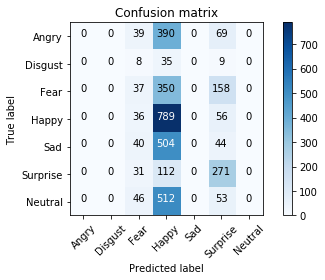

In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_true = np.load('./truey.npy')
y_pred = np.load('./predy.npy')
cm = confusion_matrix(y_true, y_pred)
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
title='Confusion matrix'
print(cm)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()